In [1]:
%pylab inline
#%matplotlib notebook
import xarray as xr
from glob import glob
from scipy import stats
import pandas as pd
#from xradd import *
from rrtmg_lw_functions import *
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
from string import ascii_lowercase
from scipy.interpolate import griddata
from netCDF4 import Dataset
from scipy import interpolate
import time
from datetime import datetime
import calendar
from datetime import timedelta 
from scipy import interpolate

Populating the interactive namespace from numpy and matplotlib


## Description

This notebook shows how I validated the heating rate kernels by comparing the kernel results with the rrtmg results. (See bottom plot) 

In the meanwhile:
I showed that the tropospheric environment difference does not contribute much to things going on in the stratosphere.

I stored the kernels in Section "Store the kernel data for future use".


### 1. Read idealized GEM profiles of P, T, and H2O.

Two files:
1. I added perturbations to 5 different altitude ranges.
2. I added perturbations layer by layer on 18 layers.

In [2]:
indir2 = '/storage/xwang/transfer_data/data/heating_rate_result_data/'
ff0 = xr.open_dataset(indir2+'idealized_gem_profiles_p_t_wv_perturb_base_radius_center_egde.nc')
p_ave = ff0.P_ave.data[0,0,:]
gas_mr_wv = ff0.gas_mr_wv.data*1e6 # convert to ppmv
T_ave = ff0.T_ave.data
T_lev = ff0.T_lev.data
ff0.close()

ff0 = xr.open_dataset(indir2+'idealized_gem_profiles_p_t_wv_perturb_base_levbyevl_radius_center_egde.nc')
gas_mr_wv2 = ff0.gas_mr_wv.data*1e6
T_ave2 = ff0.T_ave.data
T_lev2 = ff0.T_lev_up.data
p_lev = ff0.P_lev.data[0,:]
ff0.close()

In [3]:
print('Three types of base profiles:')
print(ff0.nbase.data)
print('base: no convective anomaly in T or H2O in the troposphere')
print('trop conv_e: convective anomaly in T or H2O in the troposphere, at the edge of convection')
print('trop conv_c: convective anomaly in T or H2O in the troposphere, at the center of convection')

Three types of base profiles:
['base' 'trop conv_e' 'trop_conv_c']
base: no convective anomaly in T or H2O in the troposphere
trop conv_e: convective anomaly in T or H2O in the troposphere, at the edge of convection
trop conv_c: convective anomaly in T or H2O in the troposphere, at the center of convection


### 2. Read heating rate and flux profiles from rrtmg

I input the P,T, and H2O profiles from above into the RRTMG, and got the heating rates and fluxes.

In this file, I only show clear sky results.

#### perturbation scheme:
1. for downward fluxes, perturb layer_ave and lower boundary
2. for upward fluxes, perturb layer_ave and upper boundary
3. compute heating rates using downward fluxes and upward fluxes from steps 1-2


In [4]:
indir1 = '/storage/xwang/transfer_data/data/heating_rate_result_data/rrtmg_retrieved_data/'
f1 = glob(indir1+'idealized_gem_profiles_radius_center_egde_levbylev_perturb_*up_dw_comp_clr*.nc')
f2 = glob(indir1+'idealized_gem_profiles_radius_center_egde_perturb_*up_dw_comp_clr*.nc')
f1.sort()
f2.sort()
nf = np.shape(f1)[0]


In [5]:
#### First read the rrtmg results for perturbations added to different altitude ranges.
dim = np.shape(gas_mr_wv)
nbase=dim[0]      # 3 types of bases
nperturb1=dim[1]  # The first one is a non-perturb result. The perturbations are on 4 different altitude ranges.
nbnd=dim[2]+1

glw_uflux=np.zeros((nf,nbase,nperturb1,nbnd))
glw_dflux=np.zeros((nf,nbase,nperturb1,nbnd))
glw_hr=np.zeros((nf,nbase,nperturb1,nbnd))

gsw_uflux=np.zeros((nf,nbase,nperturb1,nbnd))
gsw_dflux=np.zeros((nf,nbase,nperturb1,nbnd))
gsw_hr=np.zeros((nf,nbase,nperturb1,nbnd))

for i in range(nf):
    ff2 = xr.open_dataset(f2[i])
    glw_uflux[i,:,:] = ff2.lw_uflux.data
    glw_dflux[i,:,:] = ff2.lw_dflux.data
    glw_hr[i,:,:] = ff2.lw_hr.data
    gsw_uflux[i,:,:] = ff2.sw_uflux.data
    gsw_dflux[i,:,:] = ff2.sw_dflux.data
    gsw_hr[i,:,:] = ff2.sw_hr.data
    ff2.close()

#### Then read the rrtmg results for perturbations added layer by layer
dim = np.shape(gas_mr_wv2)
nbase=dim[0]    # 3 types of bases
nperturb=dim[1] # The first one is a non-perturb result. The perturbations are layer by layer (17 layers).
nbnd=dim[2]+1

lw_uflux=np.zeros((nf,nbase,nperturb,nbnd))
lw_dflux=np.zeros((nf,nbase,nperturb,nbnd))
lw_hr=np.zeros((nf,nbase,nperturb,nbnd))

sw_uflux=np.zeros((nf,nbase,nperturb,nbnd))
sw_dflux=np.zeros((nf,nbase,nperturb,nbnd))
sw_hr=np.zeros((nf,nbase,nperturb,nbnd))
for i in range(nf):
    ff1 = xr.open_dataset(f1[i])
    pr = ff1.lw_pr.data[0,0,:]
    lw_uflux[i,:] = ff1.lw_uflux.data
    lw_dflux[i,:] = ff1.lw_dflux.data
    lw_hr[i,:] = ff1.lw_hr.data
    sw_uflux[i,:] = ff1.sw_uflux.data
    sw_dflux[i,:] = ff1.sw_dflux.data
    sw_hr[i,:] = ff1.sw_hr.data
    ff1.close()


### 3.Plot the rrtmg results for three base cases
It aims to show that the tropospheric environment difference does not contribute much to things going on in the stratosphere.

So we can just stick to the same tropospheric profile in the future.

For the rest of the analyses, I will just use the "base: no convective anomaly in T or H2O in the troposphere"

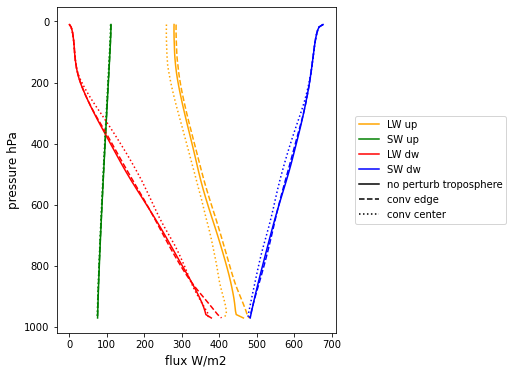

In [6]:
fig,ax = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(5,6, forward=True)

linestyle = ['-','--',':']
i1 = 0 #(0=both, 1=t, 2=wv)
i2 = 0 # 0=base,1=conv_e, 2=conv_c

for i2 in range(3):
    ax.plot(glw_uflux[i1,i2,0,:],pr,color='orange',linestyle=linestyle[i2])
    ax.plot(gsw_uflux[i1,i2,0,:],pr,color='g',linestyle=linestyle[i2])
    ax.plot(glw_dflux[i1,i2,0,:],pr,color='r',linestyle=linestyle[i2])
    ax.plot(gsw_dflux[i1,i2,0,:],pr,color='b',linestyle=linestyle[i2])

    
ax.plot(0,0,color='orange',label='LW up')
ax.plot(0,0,color='g',label='SW up')
ax.plot(0,0,color='r',label='LW dw')
ax.plot(0,0,color='b',label='SW dw')
ax.plot(0,0,color='k',linestyle='-',label='no perturb troposphere')
ax.plot(0,0,color='k',linestyle='--',label='conv edge')
ax.plot(0,0,color='k',linestyle=':',label='conv center')


ax.invert_yaxis()
ax.set_xlabel('flux W/m2',fontsize=12)
ax.set_ylabel('pressure hPa',fontsize=12)
ax.legend(loc='center left',bbox_to_anchor=(1.05, 0.5))



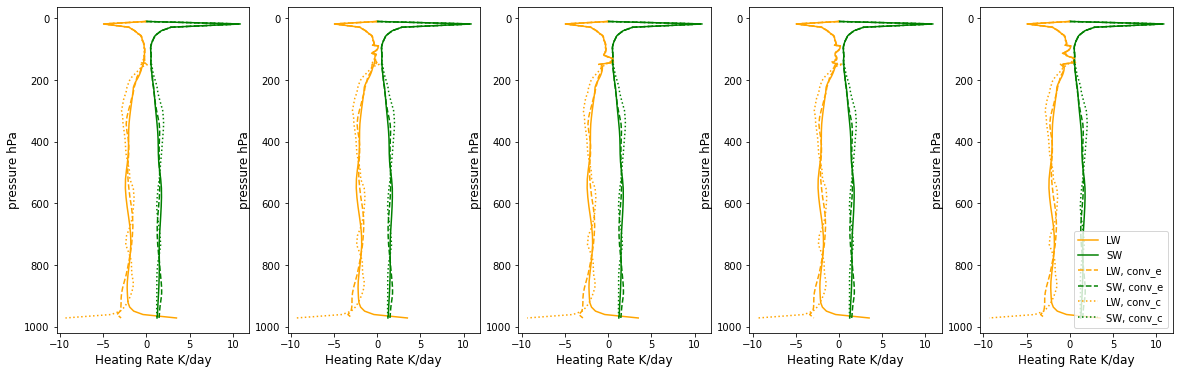

In [7]:
fig,ax = plt.subplots(nrows=1,ncols=5)
fig.set_size_inches(20,6, forward=True)

i1 = 1 #(0=both, 1=t, 2=wv)
i2 = 0 # 0=base,1=conv_e, 2=conv_c

for i in range(5):
    i2=0
    ax[i].plot(glw_hr[i1,i2,i,:],pr,color='orange',label='LW')
    ax[i].plot(gsw_hr[i1,i2,i,:],pr,color='g',label='SW')


    i2=1
    ax[i].plot(glw_hr[i1,i2,i,:],pr,color='orange',linestyle='--',label='LW, conv_e')
    ax[i].plot(gsw_hr[i1,i2,i,:],pr,color='green',linestyle='--',label='SW, conv_e')
    
    i2=2
    ax[i].plot(glw_hr[i1,i2,i,:],pr,color='orange',linestyle=':',label='LW, conv_c')
    ax[i].plot(gsw_hr[i1,i2,i,:],pr,color='green',linestyle=':',label='SW, conv_c')

    
    ax[i].invert_yaxis()
    ax[i].set_xlabel('Heating Rate K/day',fontsize=12)
    ax[i].set_ylabel('pressure hPa',fontsize=12)
ax[-1].legend(loc='lower right')
#     ax[i].set_ylim([900,0])
#     ax[i].set_xlim([900,0])


### 4. Plot delta heating rates: perturbed vs base

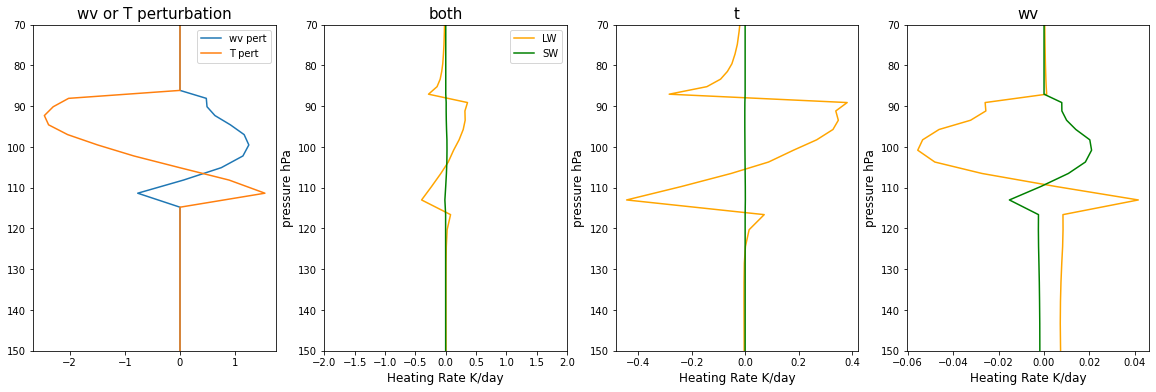

In [8]:
fig,ax = plt.subplots(nrows=1,ncols=4)
fig.set_size_inches(20,6, forward=True)
title = ['both','t','wv']

i2 = 0 # 0=base,1=conv_e, 2=conv_c
i=1 # change i for perturbation at different altitude ranges

ax[0].plot(gas_mr_wv[i2,i,:]-gas_mr_wv[i2,0,:],p_ave,label='wv pert')
ax[0].plot(T_ave[i2,i,:]-T_ave[i2,0,:],p_ave,label='T pert')
ax[0].set_ylim([150,70])
ax[0].set_title('wv or T perturbation',fontsize=15)


i1=0 # both t and wv perturbation
ax[1].plot(glw_hr[i1,i2,i,:]-glw_hr[i1,i2,0,:],pr,color='orange',label='LW')
ax[1].plot(gsw_hr[i1,i2,i,:]-gsw_hr[i1,i2,0,:],pr,color='g',label='SW')
i1=1 # t perturbation
ax[2].plot(glw_hr[i1,i2,i,:]-glw_hr[i1,i2,0,:],pr,color='orange',label='LW')
ax[2].plot(gsw_hr[i1,i2,i,:]-gsw_hr[i1,i2,0,:],pr,color='g',label='SW')
i1=2 # wv perturbation
ax[3].plot(glw_hr[i1,i2,i,:]-glw_hr[i1,i2,0,:],pr,color='orange',label='LW')
ax[3].plot(gsw_hr[i1,i2,i,:]-gsw_hr[i1,i2,0,:],pr,color='g',label='SW')


ax[1].set_xlim([-2,2])

for i in range(1,4):   
    ax[i].set_title(title[i-1],fontsize=15)
    ax[i].set_xlabel('Heating Rate K/day',fontsize=12)
    ax[i].set_ylabel('pressure hPa',fontsize=12)
    ax[i].set_ylim([150,70])
    
ax[1].legend(loc='upper right')
ax[0].legend(loc='upper right')


### 5. Plot delta heating rates: layer by layer

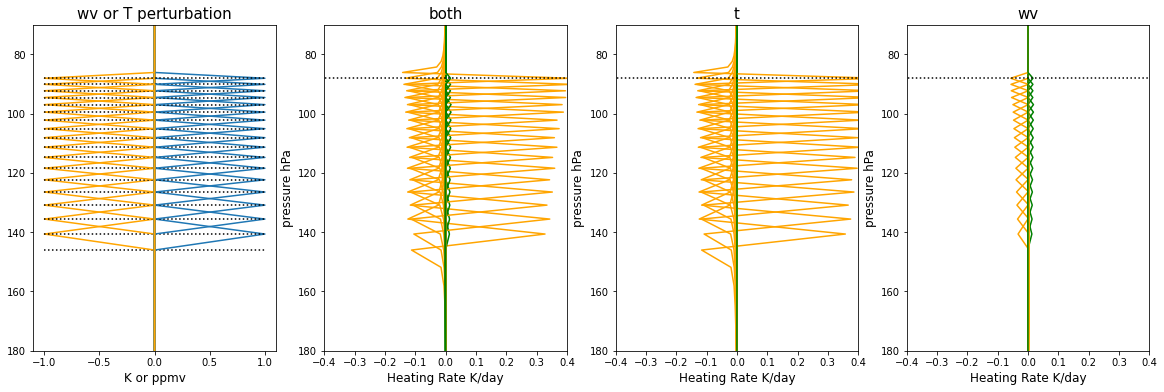

In [9]:
fig,ax = plt.subplots(nrows=1,ncols=4)
fig.set_size_inches(20,6, forward=True)
title = ['both','t','wv']

i2 = 0 # 0=with base troposphere, 1 = edge troposphere, 2=center troposphere

for i in range(18):
    ax[0].plot(gas_mr_wv2[0,i,:]-gas_mr_wv2[0,0,:],p_ave,label='wv pert',color='tab:blue')
    ax[0].plot(T_ave2[0,i,:]-T_ave2[0,0,:],p_ave,label='T_ave pert',color='orange')
    #ax[0].plot(T_lev2[0,i,:]-T_lev2[0,0,:],p_lev,label='T_lev pert',color='orange')
    ax[0].plot([-1,1],[p_ave[43+i],p_ave[43+i]],color='k',linestyle=':')
    ax[0].set_ylim([180,70])
    ax[0].set_title('wv or T perturbation',fontsize=15)
    ax[0].set_xlabel('K or ppmv',fontsize=12)

    i1=0 # both t and wv perturbation
    ax[1].plot(lw_hr[i1,i2,i,1:]-lw_hr[i1,i2,0,1:],p_ave[::-1],color='orange',label='LW')
    ax[1].plot(sw_hr[i1,i2,i,1:]-sw_hr[i1,i2,0,1:],p_ave[::-1],color='g',label='SW')
    i1=1 # t perturbation
    ax[2].plot(lw_hr[i1,i2,i,1:]-lw_hr[i1,i2,0,1:],p_ave[::-1],color='orange',label='LW')
    ax[2].plot(sw_hr[i1,i2,i,1:]-sw_hr[i1,i2,0,1:],p_ave[::-1],color='g',label='SW')
    i1=2 # wv perturbation
    ax[3].plot(lw_hr[i1,i2,i,1:]-lw_hr[i1,i2,0,1:],p_ave[::-1],color='orange',label='LW')
    ax[3].plot(sw_hr[i1,i2,i,1:]-sw_hr[i1,i2,0,1:],p_ave[::-1],color='g',label='SW')


for j in range(1,4):   
    ax[j].set_title(title[j-1],fontsize=15)
    ax[j].set_xlabel('Heating Rate K/day',fontsize=12)
    ax[j].set_ylabel('pressure hPa',fontsize=12)
    ax[j].plot([-1,1],[p_ave[43+i],p_ave[43+i]],color='k',linestyle=':')
    ax[j].set_ylim([180,70])
    ax[j].set_xlim([-0.4,0.4])
    
# ax[1].legend(loc='upper right')
# ax[0].legend(loc='upper right')

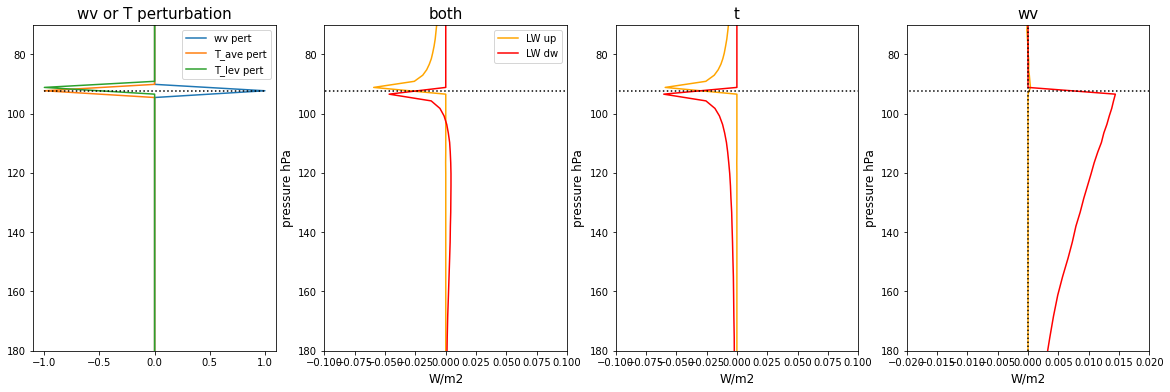

In [10]:
fig,ax = plt.subplots(nrows=1,ncols=4)
fig.set_size_inches(20,6, forward=True)
title = ['both','t','wv']

i2 = 0 # 0=with base troposphere, 1 = edge troposphere, 2=center troposphere
# we focus on pert vs base first


i=15 # change i for perturbation at different altitude ranges

ax[0].plot(gas_mr_wv2[0,i,:]-gas_mr_wv2[0,0,:],p_ave,label='wv pert')
ax[0].plot(T_ave2[0,i,:]-T_ave2[0,0,:],p_ave,label='T_ave pert')
ax[0].plot(T_lev2[0,i,:]-T_lev2[0,0,:],p_lev,label='T_lev pert')
ax[0].plot([-1,1],[p_ave[43+i],p_ave[43+i]],color='k',linestyle=':')
ax[0].set_ylim([180,70])
ax[0].set_title('wv or T perturbation',fontsize=15)

i11=0 # both t and wv perturbation
ax[1].plot(lw_uflux[i11,i2,i,:]-lw_uflux[i11,i2,0,:],p_lev[::-1],color='orange',label='LW up')
ax[1].plot(lw_dflux[i11,i2,i,:]-lw_dflux[i11,i2,0,:],p_lev[::-1],color='r',label='LW dw')

# ax[1].plot(sw_uflux[i11,i2,i,:]-sw_uflux[i11,i2,0,:],p_lev[::-1],color='g',label='SW')
# ax[1].plot(sw_dflux[i11,i2,i,:]-sw_dflux[i11,i2,0,:],p_lev[::-1],color='b',label='SW')
i11=1 # t perturbation
ax[2].plot(lw_uflux[i11,i2,i,:]-lw_uflux[i11,i2,0,:],p_lev[::-1],color='orange',label='LW')
ax[2].plot(lw_dflux[i11,i2,i,:]-lw_dflux[i11,i2,0,:],p_lev[::-1],color='r',label='LW')

# ax[2].plot(sw_uflux[i11,i2,i,:]-sw_uflux[i11,i2,0,:],p_lev[::-1],color='g',label='SW')
# ax[2].plot(sw_dflux[i11,i2,i,:]-sw_dflux[i11,i2,0,:],p_lev[::-1],color='b',label='SW')
i11=2 # wv perturbation
ax[3].plot(lw_uflux[i11,i2,i,:]-lw_uflux[i11,i2,0,:],p_lev[::-1],color='orange',label='LW')
ax[3].plot(lw_dflux[i11,i2,i,:]-lw_dflux[i11,i2,0,:],p_lev[::-1],color='r',label='LW')

# ax[3].plot(sw_uflux[i11,i2,i,:]-sw_uflux[i11,i2,0,:],p_lev[::-1],color='g',label='SW')
# ax[3].plot(sw_dflux[i11,i2,i,:]-sw_dflux[i11,i2,0,:],p_lev[::-1],color='b',label='SW')


for j in range(1,4):   
    ax[j].set_title(title[j-1],fontsize=15)
    ax[j].set_xlabel('W/m2',fontsize=12)
    ax[j].set_ylabel('pressure hPa',fontsize=12)
    ax[j].plot([-1,1],[p_ave[43+i],p_ave[43+i]],color='k',linestyle=':')
    ax[j].set_ylim([180,70])
    ax[j].set_xlim([-0.1,0.1])
ax[-1].set_xlim([-0.02,0.02])    
ax[-1].plot([0,0],[180,70],color='k',linestyle=':')
ax[1].legend(loc='upper right')
ax[0].legend(loc='upper right')

### 6. Compute heating rate kernels

#### get delta_T and delta_wv

In [11]:
delt = np.zeros((2,17,77))
delwv = np.zeros((2,17,77))
ilev11 = [51,44]
ilev22=[60,50]
for i0 in range(2):
    for i in range(17):  
        ilev1 = ilev11[i0]
        ilev2 = ilev22[i0]
#         ilev1 = 44+i
#         ilev2 = 44+i+1
        delt[i0,i,ilev1:ilev2]=T_ave[0,i0+1,ilev1:ilev2]-T_ave[0,0,ilev1:ilev2]
        delwv[i0,i,ilev1:ilev2]=gas_mr_wv[0,i0+1,ilev1:ilev2]-gas_mr_wv[0,0,ilev1:ilev2]

#### Get kernels: $K_{HR}=\frac{\delta{HR}}{\delta{X}}$. Get $\delta HR = (K_{HR}*\Delta T)$ and $\delta HR = (K_{HR}*\Delta{H2O})$

In [12]:

i2 = 0 # 0=with base troposphere, 1 = edge troposphere, 2=center troposphere

# these are kernels
t_kn_lw = np.zeros((2,17,77)) 
wv_kn_lw = np.zeros((2,17,77))
t_kn_sw = np.zeros((2,17,77))
wv_kn_sw = np.zeros((2,17,77))

# these are the dot product of kernels and delta_T or delta_wv
del_hr_t_lw = np.zeros((2,17))
del_hr_wv_lw = np.zeros((2,17))
del_hr_t_sw = np.zeros((2,17))
del_hr_wv_sw = np.zeros((2,17))

ilev11 = [51,44]
ilev22=[60,50]
lenlen = [17,ilev22[1]-ilev11[1]+1]
# i0 = 0 -> overworld perturbations
# i0 = 1 -> lowermost perturbations
for i0 in range(2):
    for i in range(lenlen[i0]):
        i11 = 1 # t perturbation
        t_kn_lw[i0,i,:]=-(lw_hr[i11,i2,i+1,1:]-lw_hr[i11,i2,0,1:])[::-1]
        del_hr_t_lw[i0,i] = np.nansum(t_kn_lw[i0,i,:]*delt[i0,i,:])
        i11 = 2 # wv perturbation
        wv_kn_lw[i0,i,]=(lw_hr[i11,i2,i+1,1:]-lw_hr[i11,i2,0,1:])[::-1]
        del_hr_wv_lw[i0,i] = np.nansum(wv_kn_lw[i0,i,:]*delwv[i0,i,:])
        i11 = 1 # t perturbation
        t_kn_sw[i0,i,:]=-(sw_hr[i11,i2,i+1,1:]-sw_hr[i11,i2,0,1:])[::-1]
        del_hr_t_sw[i0,i] = np.nansum(t_kn_sw[i0,i,:]*delt[i0,i,:])
        i11 = 2 # wv perturbation
        wv_kn_sw[i0,i,:]=(sw_hr[i11,i2,i+1,1:]-sw_hr[i11,i2,0,1:])[::-1]
        del_hr_wv_sw[i0,i] = np.nansum(wv_kn_sw[i0,i,:]*delwv[i0,i,:])

### Store the kernel data for future use:

I have already stored the dataset.

Only run it if you need to generate new data.

In [13]:
# datas = xr.Dataset({'t_kn_lw':(['alt_range','pert_pr','all_pr'],t_kn_lw),\
#                     'wv_kn_lw':(['alt_range','pert_pr','all_pr'],wv_kn_lw),\
#                     't_kn_sw':(['alt_range','pert_pr','all_pr'],t_kn_sw),\
#                     'wv_kn_sw':(['alt_range','pert_pr','all_pr'],wv_kn_sw)},\
# coords={'alt_range':(['alt_range'],['ovw','lms']),\
#         'pert_pr':(['pert_pr'],p_ave[::-1][16:33][::-1]),\
#         'all_pr':(['all_pr'],p_ave)})
# outdir = '/storage/xwang/transfer_data/data/heating_rate_result_data/'
# datas.to_netcdf(path=outdir+'heating_rate_kernels_ovw_lms_t_wv_140-88hPa.nc',mode='w',format='NETCDF4')           

### Plot the results

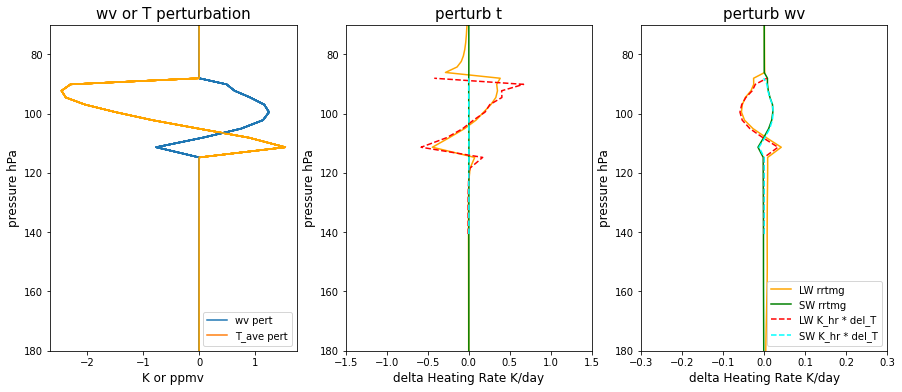

In [14]:
fig,ax = plt.subplots(nrows=1,ncols=3)
fig.set_size_inches(15,6, forward=True)
title = ['perturb t','perturb wv']
i1 = 1 #1=(clr,both),3=(clr,t),5=(clr,wv)
i2 = 0 # 0=with base troposphere, 1 = edge troposphere, 2=center troposphere
# we focus on pert vs base first


i0=0
for i in range(17):
    ax[0].plot(delwv[i0,i,:],p_ave,color='tab:blue')
    ax[0].plot(delt[i0,i,:],p_ave,color='orange')
    ax[0].set_ylim([180,70])
    ax[0].set_title('wv or T perturbation',fontsize=15)
    ax[0].set_xlabel('K or ppmv',fontsize=12)
ax[0].plot(0,0,label='wv pert',color='tab:blue')
ax[0].plot(0,0,label='T_ave pert',color='tab:orange')



for j in range(1,3):   
    ax[j].set_title(title[j-1],fontsize=15)
    ax[j].set_xlabel('delta Heating Rate K/day',fontsize=12)
    ax[j].set_ylabel('pressure hPa',fontsize=12)
    ax[j].set_ylim([180,70])
    ax[j].set_xlim([-0.3,0.3])

ax[1].set_xlim([-1.5,1.5])  
ax[0].set_ylabel('pressure hPa',fontsize=12)


ax[1].plot(glw_hr[1,0,i0+1,1:]-glw_hr[1,0,0,1:],p_ave[::-1],color='orange',linewidth=1.5)
ax[2].plot(glw_hr[2,0,i0+1,1:]-glw_hr[2,0,0,1:],p_ave[::-1],color='orange',linewidth=1.5,label='LW rrtmg ')
ax[1].plot(gsw_hr[1,0,i0+1,1:]-gsw_hr[1,0,0,1:],p_ave[::-1],color='g',linewidth=1.5)
ax[2].plot(gsw_hr[2,0,i0+1,1:]-gsw_hr[2,0,0,1:],p_ave[::-1],color='g',linewidth=1.5,label='SW rrtmg ')




ax[1].plot(del_hr_t_lw[i0,:],p_ave[44:44+17],color='r',linestyle='--',label='LW K_hr * del_wv')
ax[2].plot(del_hr_wv_lw[i0,:],p_ave[44:44+17],color='r',linestyle='--',label='LW K_hr * del_T')
ax[1].plot(del_hr_t_sw[i0,:],p_ave[44:44+17],color='cyan',linestyle='--',label='SW K_hr * del_wv')
ax[2].plot(del_hr_wv_sw[i0,:],p_ave[44:44+17],color='cyan',linestyle='--',label='SW K_hr * del_T')





ax[0].legend(loc='lower right')
ax[2].legend(loc='lower right')